In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os, sys
path = os.getcwd()
while not path.endswith('research'):    
    path = os.path.abspath(os.path.join(path, '../'))
sys.path.append(path)
sys.path.append('C:\git\statslib')
import statslib as stb
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import warnings
warnings.filterwarnings("ignore")
import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

In [3]:
import statsmodels.api as sm

In [4]:
import numpy as np
from datetime import datetime, date
import pandas as pd
import json
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import time
from copy import deepcopy
from pandas.tseries.offsets import DateOffset

In [5]:
from gmt.fom.gas.shared.utils.common import *
from gmt.fom.gas.shared.utils.dframe import *

In [6]:
from gmt.fom.gas.shared.models.stpb.data.mongo import MongoAdapter

In [7]:
figsize=(9*1.6, 9)

In [8]:
def save_to_path(f_name):
    _path = r'C:/git/gmt-fom-gas-research/sandbox/alexs/short_term_power_burn'
    return os.path.join(_path, f_name + '.csv')

In [9]:
def get_fourier_series(timeIndex,K):
    m = 365.25
    d = 1
    fourier_series = pd.DataFrame({'date':timeIndex})
    fourier_series = fourier_series.set_index(pd.PeriodIndex(fourier_series['date'], freq='D'))
    for i in range(1, K+1):
        fourier_series[f'sin365_{i}'] = np.sin(2 * i * np.pi * d * fourier_series.index.dayofyear / m)
        fourier_series[f'cos365_{i}'] = np.cos(2 * i * np.pi * d * fourier_series.index.dayofyear / m)
    fourier_series = fourier_series.drop(columns=['date'])
    fourier_series.index = fourier_series.index.to_timestamp()
    return fourier_series

# CONSTANTS

In [10]:
YEARS = 3

In [11]:
FORECAST_HORIZON = 90

In [12]:
R_DATA_PATH =  r'C:\git\gmt-fom-gas-research\sandbox\alexs\short_term_power_burn\R\data'

# DATA

In [13]:
myData = MongoAdapter()
dataDM = myData.load_design_matrix()

t_out_time = dataDM.index[-FORECAST_HORIZON:].min(); t_out_time
t_out_sample = dataDM.index[-2*FORECAST_HORIZON:].min();  t_out_sample
t_start = t_out_time - DateOffset(years=YEARS)

mask = (dataDM.index>=t_start) & (dataDM.index<t_out_sample)
dataDM = dataDM[mask]


#removing leap year for 365 exactly
# leap_year_index = dataDM[(dataDM.index.month==2) & (dataDM.index.day==29)].index; leap_year_index
# dataDM = dataDM[~dataDM.index.isin(leap_year_index)]

#adding trend explicitely
dataDM['trend'] = range(1, len(dataDM.index)+1)

# monday_thursday vs. the rest
dataDM['weekday'] = dataDM.index.weekday
dataDM['weekday'] = dataDM['weekday'].apply(lambda t: t+1)
dataDM = dataDM.join(pd.get_dummies(dataDM['weekday'], prefix='day'))
dataDM['monday_thursday'] = dataDM['weekday'].apply(lambda v: 'yes' if v>=1 and v<5 else 'no')
dataDM = dataDM.join(pd.get_dummies(dataDM['monday_thursday'], prefix='mo_th'))

#fourier series
K = 3
dataDM = dataDM.join(get_fourier_series(dataDM.index,K))

2021-04-23 16:01:18,053: c:\git\gmt-fom-gas-research\gmt\fom\gas\shared\data_sources\mongo.py: 25: DEBUG: Connected successfully.
--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\ashubert\Anaconda3\envs\gas_research\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\Users\ashubert\Anaconda3\envs\gas_research\lib\logging\handlers.py", line 394, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\Users\ashubert\Anaconda3\envs\gas_research\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'c:\\git\\gmt-fom-gas-research\\logs\\log_debug.txt' -> 'c:\\git\\gmt-fom-gas-research\\logs\\log_debug.txt.2021-03-22'
Call stack:
  File "C:\Users\ashubert\Anaconda3\envs\gas_research\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\ashubert\Anaconda3\envs\gas_resear

In [14]:
(dataDM.index.min(), dataDM.index.max())

(Timestamp('2017-11-17 00:00:00'), Timestamp('2020-08-18 00:00:00'))

In [15]:
ddff(dataDM.head())

clean_spreads  curve_103234271  curve_103234272  curve_103234276  \
day                                                                            
2017-11-17       5.281861        25.270000        10.499091              9.0   
2017-11-18       5.281861        23.345454         9.597273              9.0   
2017-11-19       5.908723        23.897272        10.153636              9.0   
2017-11-20       4.989740        25.749091        10.153636              9.1   
2017-11-21       4.998985        26.410909        10.153636              9.1   

            curve_103234278  curve_103234281  dark_spreads        gas  \
day                                                                     
2017-11-17         7.163636        25.709091     -0.391730  64.676675   
2017-11-18         7.163636        25.709091     -0.391730  57.717558   
2017-11-19         7.163636        25.709091      1.254521  64.696082   
2017-11-20         7.163636        25.709091      0.584085  68.649516   
2017-11-21         7.163636        25.709091      1.202515  58.929583   

              precip  temperature  wind  trend  weekday  day_1  day_2  day_3  \
day                                                                            
2017-11-17  1.346667     5.200000  3.03      1        5      0      0      0   
2017-11-18  1.173333     6.031818  3.63      2        6      0      0      0   
2017-11-19  1.826667     4.745455  2.09      3        7      0      0      0   
2017-11-20  3.346667     8.436364  3.17      4        1      1      0      0   
2017-11-21  5.560000    11.213636  4.23      5        2      0      1      0   

            day_4  day_5  day_6  day_7 monday_thursday  mo_th_no  mo_th_yes  \
day                                                                           
2017-11-17      0      1      0      0              no         1          0   
2017-11-18      0      0      1      0              no         1          0   
2017-11-19      0      0      0      1              no         1          0   
2017-11-20      0      0      0      0             yes         0          1   
2017-11-21      0      0      0      0             yes         0          1   

            sin365_1  cos365_1  sin365_2  cos365_2  sin365_3  cos365_3  
day                                                                     
2017-11-17 -0.689796  0.724004 -0.998830  0.048363 -0.756517 -0.653974  
2017-11-18 -0.677240  0.735762 -0.996575  0.082692 -0.789245 -0.614079  
2017-11-19 -0.664483  0.747303 -0.993141  0.116923 -0.819871 -0.572548  
2017-11-20 -0.651530  0.758623 -0.988531  0.151016 -0.848314 -0.529494  
2017-11-21 -0.638384  0.769718 -0.982752  0.184931 -0.874498 -0.485029

In [16]:
dependent_var = ['gas']; dependent_var

['gas']

In [17]:
covariates = ['clean_spreads', 'dark_spreads', 'precip', 'temperature', 'wind', 'trend',
             'curve_103234271','curve_103234272','curve_103234276','curve_103234278','curve_103234281']; '| '.join(covariates)

'clean_spreads| dark_spreads| precip| temperature| wind| trend| curve_103234271| curve_103234272| curve_103234276| curve_103234278| curve_103234281'

In [18]:
fourier_cols =  [k for k in dataDM if k.startswith('sin') or k.startswith('cos')]; '| '.join(fourier_cols)

'sin365_1| cos365_1| sin365_2| cos365_2| sin365_3| cos365_3'

In [19]:
days_cols = [v for v in dataDM.columns if v.startswith('day_')]; '| '.join(days_cols)

'day_1| day_2| day_3| day_4| day_5| day_6| day_7'

In [20]:
categorical_cols = [v for v in dataDM.columns if v.startswith('mo_')]; '| '.join(categorical_cols)

'mo_th_no| mo_th_yes'

In [21]:
aux_cols = ['monday_thursday', 'weekday']; aux_cols

['monday_thursday', 'weekday']

In [22]:
assert sorted(dependent_var + covariates + fourier_cols + days_cols + categorical_cols + aux_cols) == sorted(dataDM.columns)

In [23]:
# categorical: remove the last level
try:
    days_cols.remove('day_7')
    categorical_cols.remove('mo_th_no')
except Exception as e:
    print(e.args[0])
    pass

# Design Matrix

In [24]:
y = dataDM[dependent_var]; f = stb.transforms.identical(); y.head(1)

gas
day                  
2017-11-17  64.676675

In [25]:
stb.stat_tests.test_kpss(f(y))

H0: observable time series is stationary around a constant

Results of KPSS Test:
Test Statistic            1.354801
p-value                   0.010000
Lags Used                22.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

Can NOT reject H0


In [26]:
stb.stat_tests.test_adf(f(y))

H0: unit root present in the time series

Results of Dickey-Fuller Test:
Test Statistic                  -3.418319
p-value                          0.010350
#Lags Used                      21.000000
Number of Observations Used    982.000000
Critical Value (1%)             -3.437027
Critical Value (5%)             -2.864488
Critical Value (10%)            -2.568340
dtype: float64

Can NOT reject H0


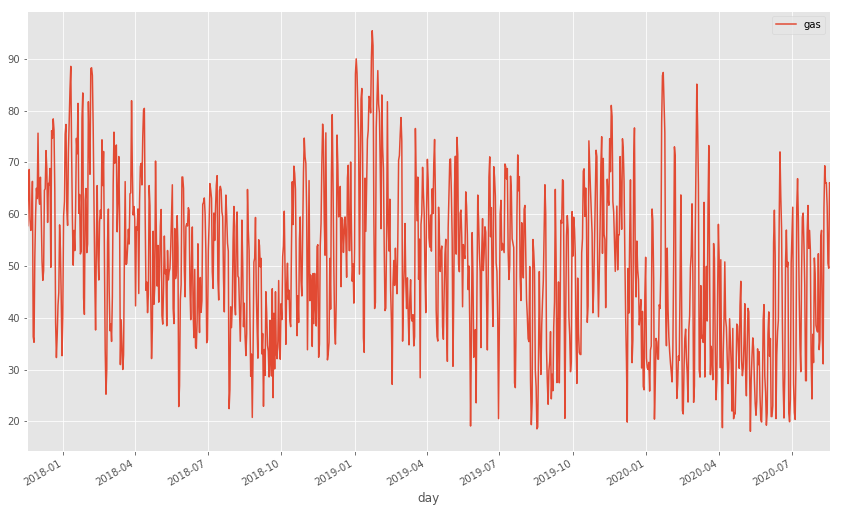

In [27]:
fig, ax = plt.subplots(figsize=figsize)
y.plot(ax=ax)
plt.savefig(r'C:\temp\{}.png'.format('DependentVariable'), bbox_inches = 'tight', pad_inches = 0)

***

In [28]:
gs = dict()

In [29]:
g1 = stb.transforms.identical(); gs.update(dict(zip(covariates, [g1]*len(covariates))))

In [30]:
g2 = stb.transforms.identical(); 
gs.update(dict(zip(categorical_cols, [g2]*len(categorical_cols))))

In [31]:
gs.update(dict(trend=stb.transforms.identical()))

In [32]:
X = dataDM[covariates + categorical_cols]; X.head(2)

clean_spreads  dark_spreads    precip  temperature  wind  trend  \
day                                                                           
2017-11-17       5.281861      -0.39173  1.346667     5.200000  3.03      1   
2017-11-18       5.281861      -0.39173  1.173333     6.031818  3.63      2   

            curve_103234271  curve_103234272  curve_103234276  \
day                                                             
2017-11-17        25.270000        10.499091              9.0   
2017-11-18        23.345454         9.597273              9.0   

            curve_103234278  curve_103234281  mo_th_yes  
day                                                      
2017-11-17         7.163636        25.709091          0  
2017-11-18         7.163636        25.709091          0

In [33]:
DM = stb.DesignMatrix(y=y, X=X, f=f, gs=gs, add_const=True)

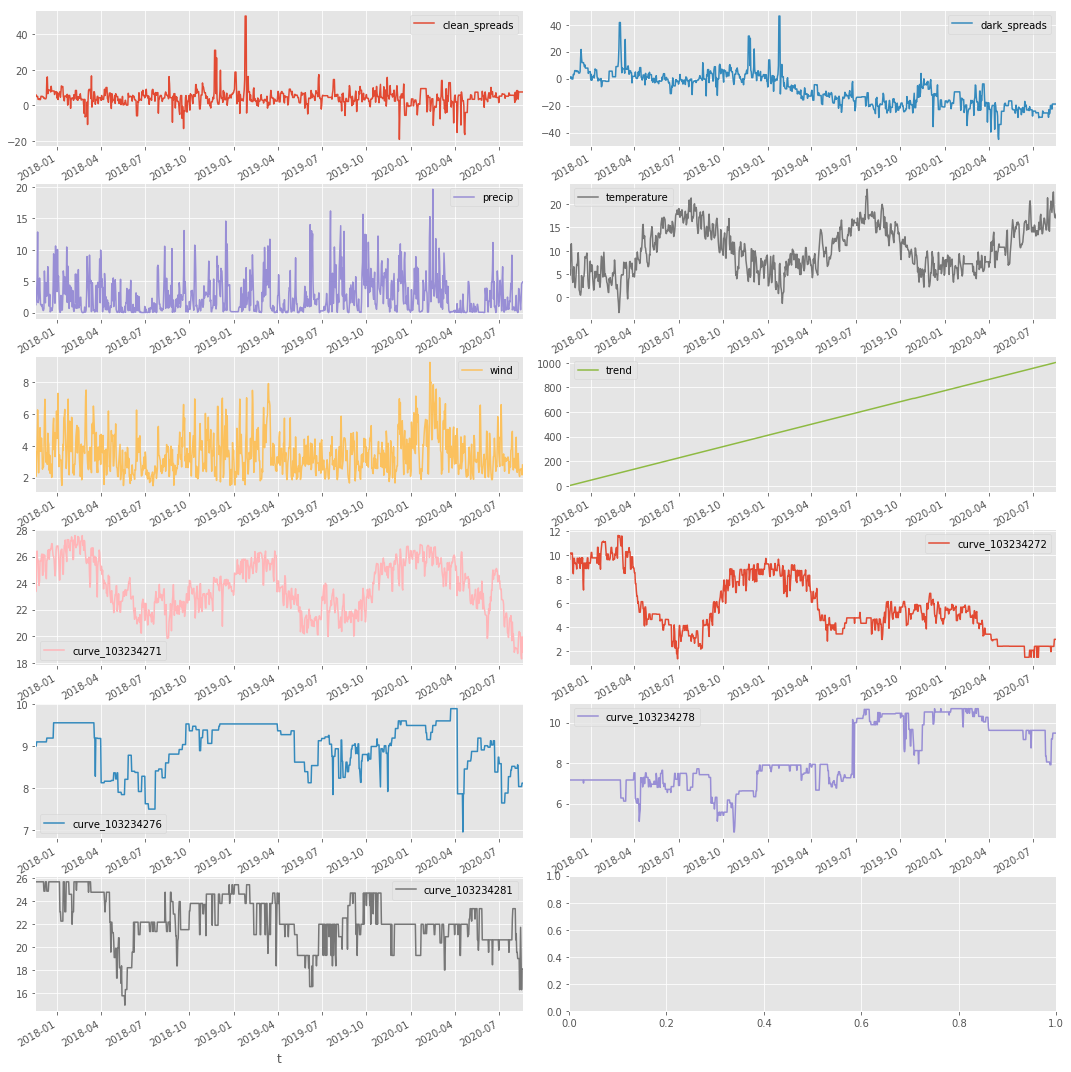

In [34]:
DM.plot(only_names=covariates)

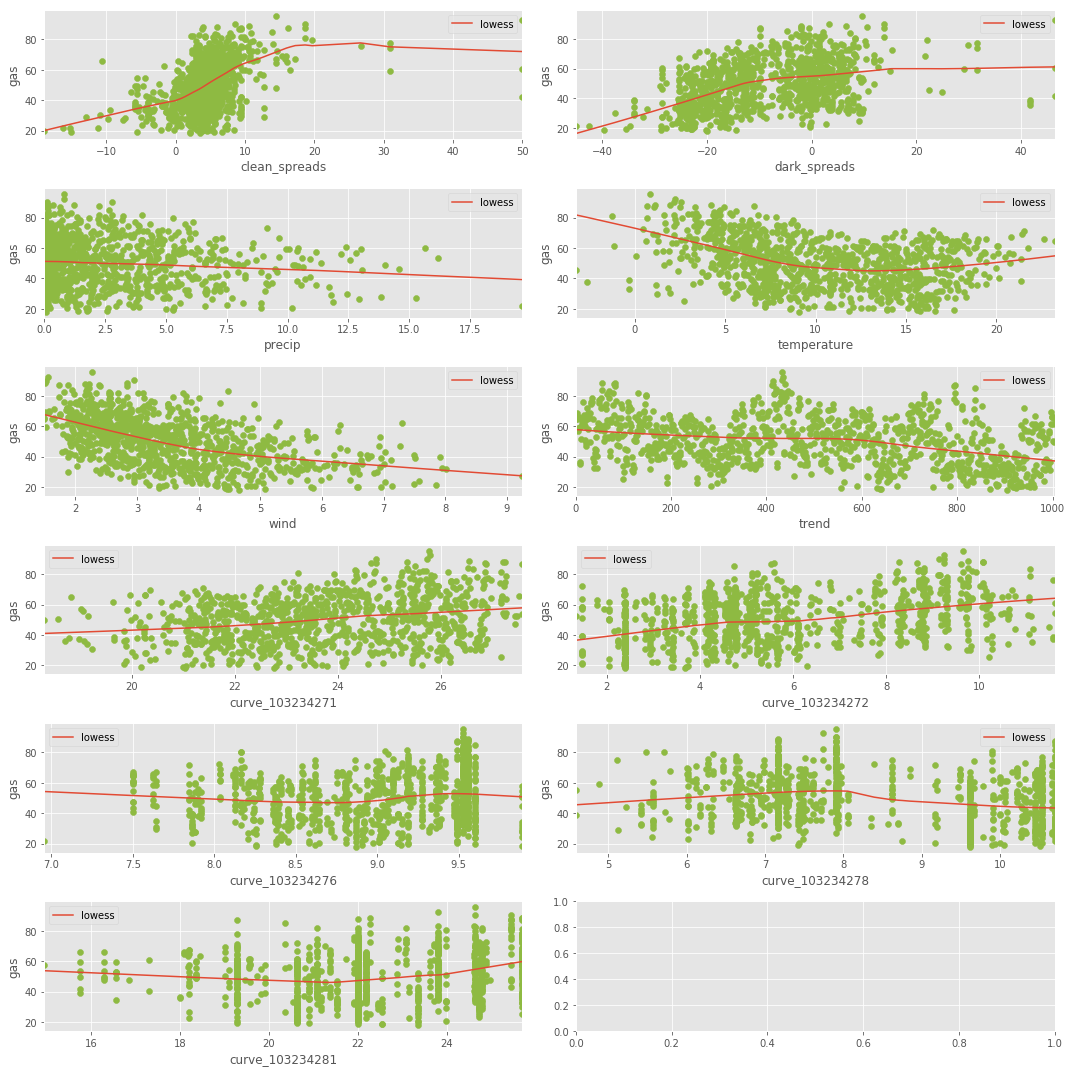

In [35]:
DM.plot_scatter_lowess(drop_names=categorical_cols + fourier_cols)

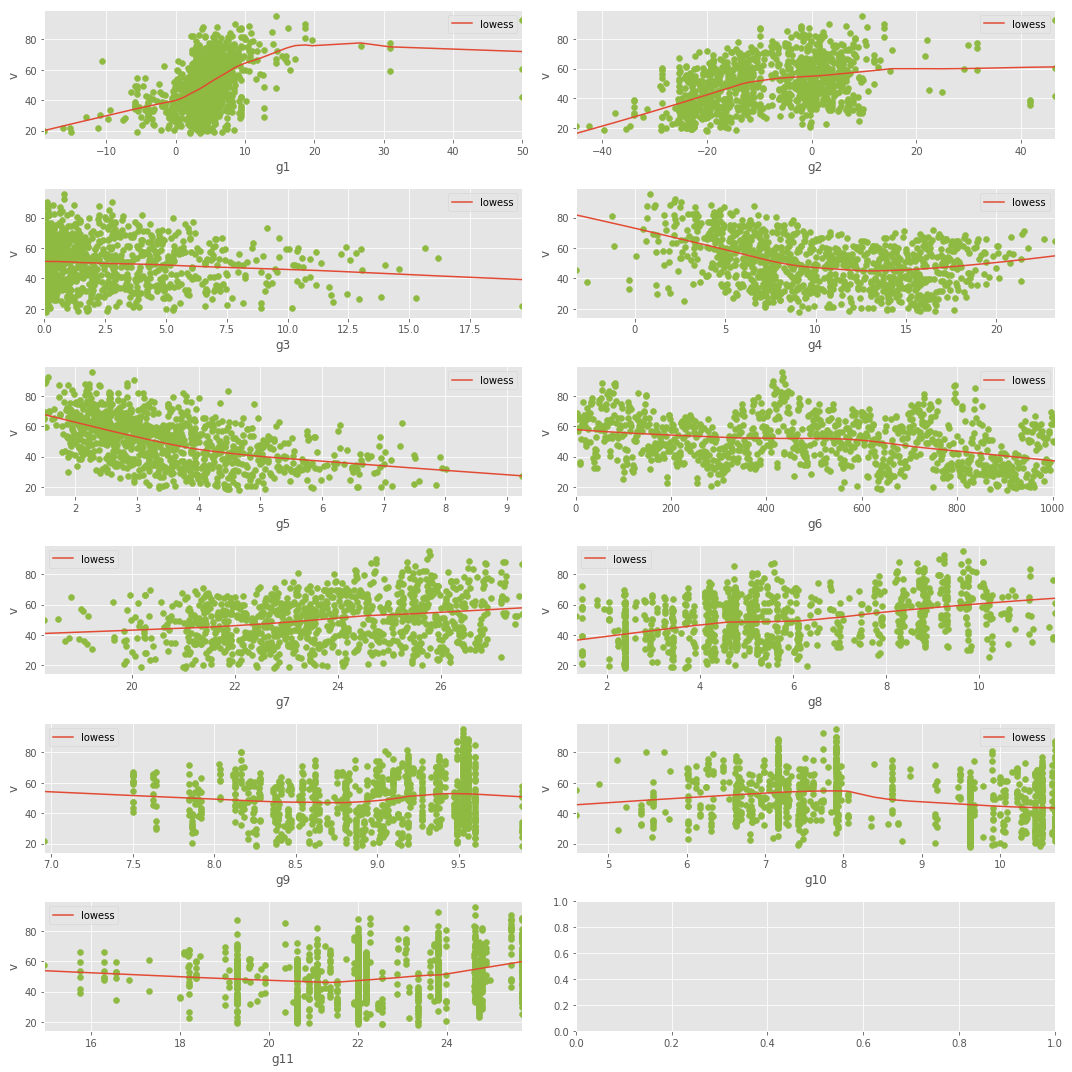

In [36]:
DM.plot_scatter_lowess(drop_names=categorical_cols + fourier_cols, g_form=True)

## Exog specification <- grid search

In [37]:
from itertools import product
from functools import partial

powerset = partial(stb.utils.common.powerset, skip_empty_set=True)

nms = DM.x_to_g(covariates) + DM.x_to_g(categorical_cols)

grid = product(['const'], powerset(nms))
results = []
N = len(list(grid))
grid = powerset(nms)
i=0
for elem in grid:
    print(f'{N-i}', end='| ')
    nm = ['const']+list(elem)
    try:
        gc = stb.GeneralCalibrator(sm.tsa.statespace.SARIMAX, 
                               dict(order=(1,0,1), 
                               trend='n', 
                               enforce_stationarity=True,
                               seasonal_order=(1, 0, 1, 7)))
        nDM = deepcopy(DM)
        nDM.gX = nDM.gX[nm]
        gm = stb.GeneralModel(gc, nDM)
        gm.fit(range(DM.dm.shape[0]))
        results.append([elem, gm.fitted.bic, nm])
    except Exception as e:
        print(e.args[0])
        continue
    i+=1

df_res = pd.DataFrame(results, columns=['elem', 'metric', 'config']).sort_values(
    by=['metric'], ascending=True)[['config', 'metric']]


specification = df_res.head(1)['config'].values.tolist()[0];
display.display(df_res.head(5))
print(specification)
print('| '.join(DM.g_to_x(specification)))

4095| 4094| 4093| 4092| 4091| 4090| 4089| 4088| 4087| 4086| 4085| 4084| 4083| 4082| 4081| 4080| 4079| 4078| 4077| 4076| 4075| 4074| 4073| 4072| 4071| 4070| 4069| 4068| 4067| 4066| 4065| 4064| 4063| 4062| 4061| 4060| 4059| 4058| 4057| 4056| 4055| 4054| 4053| 4052| 4051| 4050| 4049| 4048| 4047| 4046| 4045| 4044| 4043| 4042| 4041| 4040| 4039| 4038| 4037| 4036| 4035| 4034| 4033| 4032| 4031| 4030| 4029| 4028| 4027| 4026| 4025| 4024| 4023| 4022| 4021| 4020| 4019| 4018| 4017| 4016| 4015| 4014| 4013| 4012| 4011| 4010| 4009| 4008| 4007| 4006| 4005| 4004| 4003| 4002| 4001| 4000| 3999| 3998| 3997| 3996| 3995| 3994| 3993| 3992| 3991| 3990| 3989| 3988| 3987| 3986| 3985| 3984| 3983| 3982| 3981| 3980| 3979| 3978| 3977| 3976| 3975| 3974| 3973| 3972| 3971| 3970| 3969| 3968| 3967| 3966| 3965| 3964| 3963| 3962| 3961| 3960| 3959| 3958| 3957| 3956| 3955| 3954| 3953| 3952| 3951| 3950| 3949| 3948| 3947| 3946| 3945| 3944| 3943| 3942| 3941| 3940| 3939| 3938| 3937| 3936| 3935| 3934| 3933| 3932| 3931| 3930| 3929

2729| 2728| 2727| 2726| 2725| 2724| 2723| 2722| 2721| 2720| 2719| 2718| 2717| 2716| 2715| 2714| 2713| 2712| 2711| 2710| 2709| 2708| 2707| 2706| 2705| 2704| 2703| 2702| 2701| 2700| 2699| 2698| 2697| 2696| 2695| 2694| 2693| 2692| 2691| 2690| 2689| 2688| 2687| 2686| 2685| 2684| 2683| 2682| 2681| 2680| 2679| 2678| 2677| 2676| 2675| 2674| 2673| 2672| 2671| 2670| 2669| 2668| 2667| 2666| 2665| 2664| 2663| 2662| 2661| 2660| 2659| 2658| 2657| 2656| 2655| 2654| 2653| 2652| 2651| 2650| 2649| 2648| 2647| 2646| 2645| 2644| 2643| 2642| 2641| 2640| 2639| 2638| 2637| 2636| 2635| 2634| 2633| 2632| 2631| 2630| 2629| 2628| 2627| 2626| 2625| 2624| 2623| 2622| 2621| 2620| 2619| 2618| 2617| 2616| 2615| 2614| 2613| 2612| 2611| 2610| 2609| 2608| 2607| 2606| 2605| 2604| 2603| 2602| 2601| 2600| 2599| 2598| 2597| 2596| 2595| 2594| 2593| 2592| 2591| 2590| 2589| 2588| 2587| 2586| 2585| 2584| 2583| 2582| 2581| 2580| 2579| 2578| 2577| 2576| 2575| 2574| 2573| 2572| 2571| 2570| 2569| 2568| 2567| 2566| 2565| 2564| 2563

1363| 1362| 1361| 1360| 1359| 1358| 1357| 1356| 1355| 1354| 1353| 1352| 1351| 1350| 1349| 1348| 1347| 1346| 1345| 1344| 1343| 1342| 1341| 1340| 1339| 1338| 1337| 1336| 1335| 1334| 1333| 1332| 1331| 1330| 1329| 1328| 1327| 1326| 1325| 1324| 1323| 1322| 1321| 1320| 1319| 1318| 1317| 1316| 1315| 1314| 1313| 1312| 1311| 1310| 1309| 1308| 1307| 1306| 1305| 1304| 1303| 1302| 1301| 1300| 1299| 1298| 1297| 1296| 1295| 1294| 1293| 1292| 1291| 1290| 1289| 1288| 1287| 1286| 1285| 1284| 1283| 1282| 1281| 1280| 1279| 1278| 1277| 1276| 1275| 1274| 1273| 1272| 1271| 1270| 1269| 1268| 1267| 1266| 1265| 1264| 1263| 1262| 1261| 1260| 1259| 1258| 1257| 1256| 1255| 1254| 1253| 1252| 1251| 1250| 1249| 1248| 1247| 1246| 1245| 1244| 1243| 1242| 1241| 1240| 1239| 1238| 1237| 1236| 1235| 1234| 1233| 1232| 1231| 1230| 1229| 1228| 1227| 1226| 1225| 1224| 1223| 1222| 1221| 1220| 1219| 1218| 1217| 1216| 1215| 1214| 1213| 1212| 1211| 1210| 1209| 1208| 1207| 1206| 1205| 1204| 1203| 1202| 1201| 1200| 1199| 1198| 1197

config       metric
1071          [const, g1, g5, g7, g8, g12]  6833.444882
1939      [const, g1, g4, g5, g7, g8, g12]  6834.603615
1007          [const, g1, g4, g5, g7, g12]  6835.456762
1869      [const, g1, g3, g5, g7, g8, g12]  6836.553080
2779  [const, g1, g3, g4, g5, g7, g8, g12]  6836.965406

['const', 'g1', 'g5', 'g7', 'g8', 'g12']
const| clean_spreads| wind| curve_103234271| curve_103234272| mo_th_yes


In [1]:
specification = list(map(DM._inv_names.get, [
    'const','clean_spreads', 'wind', 'curve_103234271', 'curve_103234272', 'mo_th_yes'
     ]));

specification

NameError: name 'DM' is not defined

In [38]:
specification = DM.g_to_x(specification);specification

['const',
 'clean_spreads',
 'wind',
 'curve_103234271',
 'curve_103234272',
 'mo_th_yes']

In [39]:
DM._inv_names.values()

dict_values(['v', 'g1', 'g2', 'g3', 'g4', 'g5', 'g6', 'g7', 'g8', 'g9', 'g10', 'g11', 'g12', 'const'])

In [40]:
DM.x_to_g(specification)

['const', 'g1', 'g5', 'g7', 'g8', 'g12']

In [41]:
specification

['const',
 'clean_spreads',
 'wind',
 'curve_103234271',
 'curve_103234272',
 'mo_th_yes']

In [42]:
DM.g_to_x(DM.x_to_g(specification))

['const',
 'clean_spreads',
 'wind',
 'curve_103234271',
 'curve_103234272',
 'mo_th_yes']

In [43]:
DM.x_to_g(DM.x_to_g(specification))

['const', 'g1', 'g5', 'g7', 'g8', 'g12']

In [44]:
DM.x_to_g(DM.g_to_x(specification))

['const', 'g1', 'g5', 'g7', 'g8', 'g12']

In [45]:
DM.g_to_x(DM.g_to_x(specification))

['const',
 'clean_spreads',
 'wind',
 'curve_103234271',
 'curve_103234272',
 'mo_th_yes']

## AR(I)MA Grid Search

# Cross-validation

In [46]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=6, test_size=FORECAST_HORIZON)
splits = [(train_idx, test_idx) for train_idx, test_idx in tscv.split(DM.dm.index)]

In [47]:
metric = stb.metrics.root_mean_squared_error

## Grid Search

In [48]:
gc = stb.GeneralCalibrator(sm.tsa.statespace.SARIMAX, 
                               dict(order=(1,0,1), 
                               trend='n', 
                               enforce_stationarity=True,
                               seasonal_order=(1, 0, 1, 7)))
nDM = deepcopy(DM)
nDM.gX = nDM.gX[DM.x_to_g(specification)]
gm = stb.GeneralModel(gc, nDM)
cv = stb.CrossValidation(gm, splits, metric=metric)
cv_m, cv_std = cv.run(False)

y_range = nDM.y.max() - nDM.y.min();
print(f'CV_error/range: {cv_m/y_range*100:.2f}% | (range: {y_range:.0f})')

ValueError: Provided exogenous values are not of the appropriate shape. Required (92, 6), got (90, 6).

## In sample

In [ ]:
specification

In [ ]:
nDM = deepcopy(DM)
nDM.gX = nDM.gX[DM.x_to_g(specification)]
gm = stb.GeneralModel(gc, nDM)
gm.fit(range(DM.n))
gm.forecast(range(DM.n))
print(gm.fitted.summary())
gm.plot_diagnostics(drop_names=categorical_cols+fourier_cols)
stb.stat_plots.plot_acf_pcf(gm.std_residuals, kwargs_acf={'lags': 90}, kwargs_pacf={'lags':90})

NOBS = gm.fitted.nobs

In [ ]:
exog = DM.gX[DM.x_to_g(specification)]
v_hat = gm.fitted.predict(start=exog.index.min(), 
                          end=exog.index.max(), 
                          exog=exog)
y_hat = DM.f.inv(v_hat, y0=DM.dm.y[DM.dm.index.max()])
in_sample_error = metric(DM.y.loc[y_hat.index], y_hat)
print(f'Error: {in_sample_error:.2f}')

fig, ax = plt.subplots(figsize=figsize)
y_hat.plot(ax=ax)
DM.y.loc[y_hat.index].plot(ax=ax)
ax.legend(['pred', 'true', 'hist'])
title = f'ARIMAX in-sample  error={in_sample_error:.2f}'
ax.set_title(title)
plt.savefig(r'C:\temp\{}.png'.format(title), bbox_inches = 'tight', pad_inches = 0)
plt.show()

## Out of sample

In [ ]:
data = myData.load_design_matrix()

outDataDM = deepcopy(data[(data.index>=t_out_sample) & (data.index<t_out_time)]);

outY = outDataDM[dependent_var]

#adding trend explicitely
outDataDM['trend'] = range(1, len(outDataDM.index)+1)

# monday_thursday vs. the rest
outDataDM['weekday'] = outDataDM.index.weekday
outDataDM['weekday'] = outDataDM['weekday'].apply(lambda t: t+1)
outDataDM = outDataDM.join(pd.get_dummies(outDataDM['weekday'], prefix='day'))
outDataDM['monday_thursday'] = outDataDM['weekday'].apply(lambda v: 'yes' if v>=1 and v<5 else 'no')
outDataDM = outDataDM.join(pd.get_dummies(outDataDM['monday_thursday'], prefix='mo_th'))

#fourier series
outDataDM = outDataDM.join(get_fourier_series(outDataDM.index, K))

outX = outDataDM[covariates + categorical_cols]; #outX.head(2)

outDM = stb.DesignMatrix(y=outY, X=outX, f=DM.f, gs=DM.gs, add_const=True)


gm.fitted.params.to_frame().T.rename(columns=DM.names).T

***

In [ ]:
DM.x_to_g(specification)

In [ ]:
outDM.x_to_g(specification)

In [ ]:
exog = outDM.gX[outDM.x_to_g(specification)]
v_hat = gm.fitted.predict(start=exog.index.min(), 
                          end=exog.index.max(), 
                          exog=exog)
y_hat = DM.f.inv(v_hat, y0=DM.dm.y[DM.dm.index.max()])
out_of_sample_error = metric(outDM.y.loc[y_hat.index], y_hat)
print(f'Error: {out_of_sample_error:.2f}')

fig, ax = plt.subplots(figsize=figsize)
y_hat.plot(ax=ax)
outDM.y.loc[y_hat.index].plot(ax=ax)
DM.dm.y[-int(FORECAST_HORIZON/2):].plot(ax=ax)
ax.legend(['pred', 'true', 'hist'])
title = f'ARIMAX out-sample  t={FORECAST_HORIZON} error={out_of_sample_error:.2f}'
ax.set_title(title)
plt.savefig(r'C:\temp\{}.png'.format(title), bbox_inches = 'tight', pad_inches = 0)
plt.show()

# Out of time

In [ ]:
data = myData.load_design_matrix()

outTimeDataDM = deepcopy(data[int(-NOBS-FORECAST_HORIZON):])

outTimeY = outTimeDataDM[dependent_var]

#adding trend explicitely
outTimeDataDM['trend'] = range(1, len(outTimeDataDM.index)+1)

# monday_thursday vs. the rest
outTimeDataDM['weekday'] = outTimeDataDM.index.weekday
outTimeDataDM['weekday'] = outTimeDataDM['weekday'].apply(lambda t: t+1)
outTimeDataDM = outTimeDataDM.join(pd.get_dummies(outTimeDataDM['weekday'], prefix='day'))
outTimeDataDM['monday_thursday'] = outTimeDataDM['weekday'].apply(lambda v: 'yes' if v>=1 and v<5 else 'no')
outTimeDataDM = outTimeDataDM.join(pd.get_dummies(outTimeDataDM['monday_thursday'], prefix='mo_th'))

#fourier series
outTimeDataDM = outTimeDataDM.join(get_fourier_series(outTimeDataDM.index, K))

ddff(outTimeDataDM.head())

outX = outTimeDataDM[covariates + categorical_cols]; outX.head(2)

outTimeDM = stb.DesignMatrix(y=outTimeY, X=outX, f=f, gs=gs, add_const=True)

# ddff(outTimeDM.dm.head(2))

In [ ]:
nDM = deepcopy(outTimeDM)
nDM.gX = nDM.gX[outTimeDM.x_to_g(specification)].rename(columns=outTimeDM.names)
gm = stb.GeneralModel(gc, nDM)
gm.fit(range(outTimeDM.n-FORECAST_HORIZON))

gm.forecast(range(outTimeDM.n-FORECAST_HORIZON, outTimeDM.n))

v_hat = gm.v_hat
y_hat = gm.y_hat

fig, ax = plt.subplots(figsize=figsize)
data.gas.iloc[:-(FORECAST_HORIZON)].iloc[-int(FORECAST_HORIZON/2):].plot(ax=ax)
y_hat.plot(ax=ax)
ax.legend(['actuals', 'forecast'])
plt.show()

In [ ]:
print(gm.fitted.summary())

## Benchmark from PointValue

# SUMMARY

In [ ]:
path = r'C:\git\gmt-fom-gas-research\sandbox\alexs\short_term_power_burn\results'
cfn = stb.utils.file.create_file_name

summary_dict = dict(zip(['YEARS',
'FORECAST_HORIZON',
'cv_m',
'cv_std',
'in_sample_error',
'out_of_sample_error'],
[YEARS,
FORECAST_HORIZON,
round(cv_m,2),
round(cv_std,4),
round(in_sample_error, 4),
round(out_of_sample_error,2)]))
summary_dict.update(dict(zip(specification, DM.g_to_x(specification))))
summary_dict.update(dict(cf=gc.cf.__name__))
transforms_dict = {k:v.__str__().split('transforms.')[1].split(' ')[0] for k,v in gs.items()}
summary_dict.update(dict(gs=transforms_dict))
summary_dict
pd.DataFrame.from_dict(summary_dict, orient='index').T.to_json(cfn(folder=path, extension='json', silent=False))

In [ ]:
mySmartData = stb.SmartData()
mySmartData.acquire.from_folder(path)
mask = ['FORECAST_HORIZON', 'YEARS', 'cf', 'cv_m', 'cv_std', 'in_sample_error', 'out_of_sample_error' ]
pd.concat([mySmartData.get(name) for name in mySmartData.sourced.names]).reset_index(drop=True).sort_index(ascending=False)[mask].head(10)